/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
step 1: elapsed 1.274996042251587
step 2: elapsed 0.012722015380859375


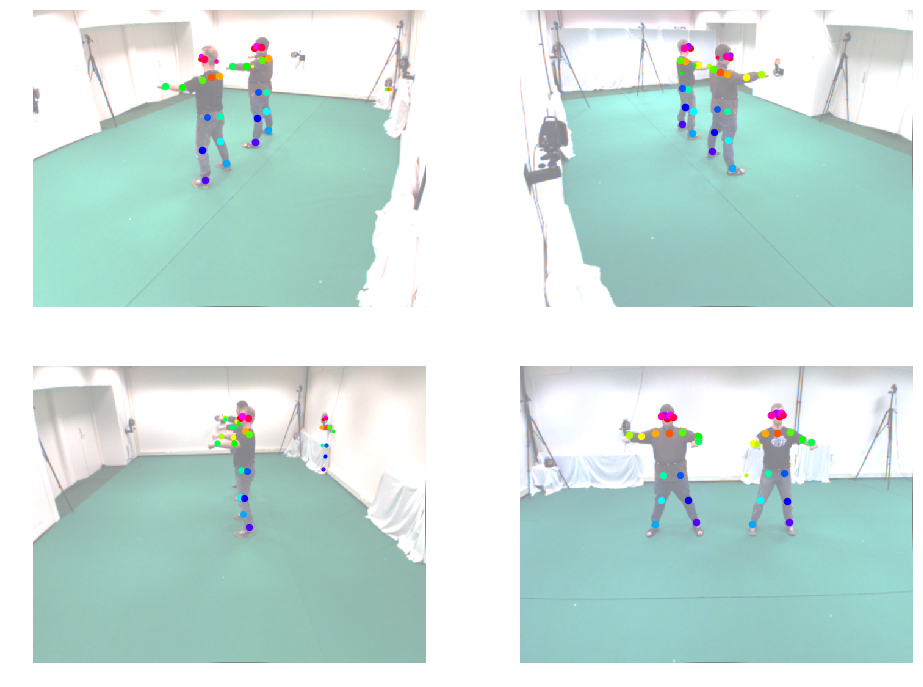

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

# **************************** #
FRAME = 0
# **************************** #

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, FRAME)

# ==================================
from mvpose import pose
Debug = pose.estimate(Calib, heatmaps, pafs, debug=True)
# ==================================

colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    mapx, mapy = Debug.candidates2d.undistort_maps[cid]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.show()

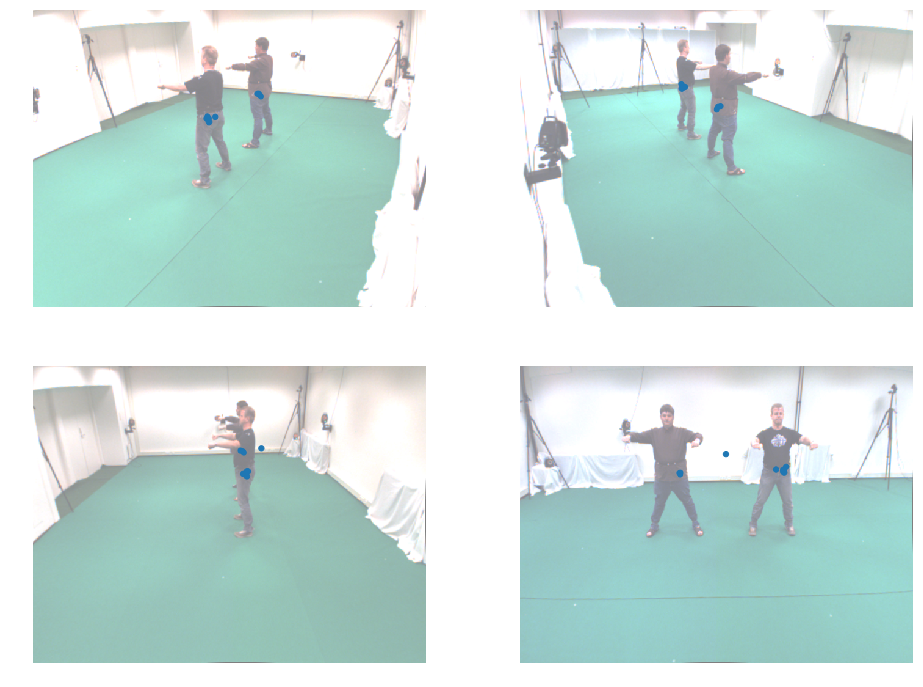

In [2]:
import mvpose.geometry.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Debug.candidates2d.Calib_undistorted)):
    ax = fig.add_subplot(2, 2, cid+1)
    mapx, mapy = Debug.candidates2d.undistort_maps[cid]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    assert distCoef == 0
    pts2d = np.squeeze(
        cv2.projectPoints(pts3d, rvec, tvec, K, np.zeros((5,1)))[0])
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
plt.show()